# Movie Recommendation 


## The MovieLens Dataset
Contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users.


# Data Processing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating','user_emb_id'])

# Reading users file
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

print(users.shape, len(users))
print(movies.shape, len(movies))
print(ratings.shape, len(ratings))

((6040, 5), 6040)
((3883, 3), 3883)
((1000209, 4), 1000209)


In [3]:
# Check the top 5 rows
print(ratings.head())

   user_id  movie_id  rating  user_emb_id
0        1      1193       5            0
1        1       661       3            0
2        1       914       3            0
3        1      3408       4            0
4        1      2355       5            0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
user_id        1000209 non-null int64
movie_id       1000209 non-null int64
rating         1000209 non-null int64
user_emb_id    1000209 non-null int64
dtypes: int64(4)
memory usage: 30.5 MB
None
('Describe Ratings: \n', count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64)


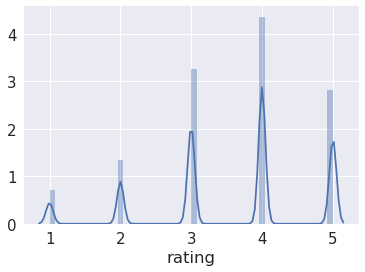

In [4]:
# Check the file info
print(ratings.info())
# Get summary statistics of rating
print("Describe Ratings: \n", ratings['rating'].describe())


# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

In [5]:
# Check the top 5 rows
print(users.head())

   user_id gender zipcode  age_desc              occ_desc
0        1      F   48067  Under 18          K-12 student
1        2      M   70072       56+         self-employed
2        3      M   55117     25-34             scientist
3        4      M   02460     45-49  executive/managerial
4        5      M   55455     25-34                writer


In [6]:
# Check the top 5 rows
print(movies.head())

   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy


In [7]:
# Check the file info
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movie_id    3883 non-null int64
title       3883 non-null object
genres      3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None


# Data Preparation

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading ratings file
# Ignore the timestamp column
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])

# Reading users file
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

# Join all 3 files into one dataframe
dataset = pd.merge(pd.merge(movies, ratings),users)

# Display 20 movies with highest ratings
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(20)

# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[[u'Drama', 1603],
 [u'Comedy', 1200],
 [u'Action', 503],
 [u'Thriller', 492],
 [u'Romance', 471]]

# Content based filtering
A Content-Based Recommendation Engine that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre.

In [9]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn import cross_validation as cv
from sklearn.feature_extraction.text import TfidfVectorizer

# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

/home/deb/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


To judge the machine's performance qualitatively use TfidfVectorizer function from scikit-learn, which transforms text to feature vectors that can be used as input to estimator.

In [10]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

#Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

Function that gets movie recommendations based on the cosine similarity score of movie genres. It returns the 20 most 
similar movies based on the cosine similarity score.

In [11]:
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [12]:
#Top recommendations for a few movies
#genre_recommendations('Good Will Hunting (1997)').head(20)
#genre_recommendations('Saving Private Ryan (1998)').head(20)

## Two collaborative filtering approaches: Memory-based approach and Model-based approach

In [13]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn-images-1.medium.com/max/2000/1*7uW5hLXztSu_FOmZOWpB6g.png")

# 1. Memory based approach: 
### User-based filtering and Item-based filtering

In [14]:
import numpy as np

percent  = 0.001  #0.1 #0.3
chosen_idx = np.random.choice(len(users), replace=False, size=int(len(users)*percent))
users = users.iloc[chosen_idx]
chosen_idx = np.random.choice(len(movies), replace=False, size=int(len(movies)*percent))
movies = movies.iloc[chosen_idx]
chosen_idx = np.random.choice(len(ratings), replace=False, size=int(len(ratings)*percent))
small_data = ratings.iloc[chosen_idx]

print(ratings.shape,small_data.shape)

((1000209, 3), (1000, 3))


In [15]:
from sklearn import cross_validation as cv
from sklearn.metrics.pairwise import pairwise_distances

# Fill NaN values in user_id and movie_id column with 0

small_data['user_id'] = small_data['user_id'].fillna(0)
small_data['movie_id'] = small_data['movie_id'].fillna(0)

# Replace NaN values in rating column with average of all values
small_data['rating'] = small_data['rating'].fillna(small_data['rating'].mean())

train_data, test_data = cv.train_test_split(small_data, test_size=0.2)

# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data.as_matrix(columns = ['rating'])
test_data_matrix = test_data.as_matrix(columns = ['rating'])

# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
#print(user_correlation[:4, :4])

# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
#print(item_correlation[:4, :4])

# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred


from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

/home/deb/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/deb/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/deb/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

(800, 1)
(200, 1)
User-based CF RMSE: 1.65529453572
Item-based CF RMSE: 1.65529453572
User-based CF RMSE: 0.0
Item-based CF RMSE: 0.0


# Deep Learning Models

The basic idea is that the actual ratings of movies for each user can be represented by a matrix, say of users on the rows and movies along the columns.  
We don’t have the full rating matrix, instead, we have a very sparse set of entries. 
But if we could factor the rating matrix into two separate matrices, say one that was Used by Latent Factors, and one that was Latent Factors by Movies, then we could find the user’s rating for any movie by taking the dot product of the User row and the Movie column.

Y = Ratings.
X1, X2 = Movies, Users.

# Deep Learning Model 1

The user latent features and movie latent features are looked up from the embedding matrices for specific movie-user combination. These are the input values for further linear and non-linear layers. We can pass this input to multiple relu, linear or sigmoid layers and learn the corresponding weights by any optimization algorithm (Adam, SGD, etc.).

## The Model
- A left embedding layer that creates a Users by Latent Factors matrix.
- A right embedding layer that creates a Movies by Latent Factors matrix.
- When the input to these layers are (i) a user id and (ii) a movie id, they'll return the latent factor vectors for the user and the movie, respectively.
A merge layer that takes the dot product of these two latent vectors to return the predicted rating.

In [16]:
import numpy as np
from keras.layers import Embedding, Reshape, Merge
from keras.models import Sequential

class CFModel(Sequential):

    # The constructor for the class
    def __init__(self, n_users, m_items, k_factors, **kwargs):
        # P is the embedding layer that creates an User by latent factors matrix.
        # If the intput is a user_id, P returns the latent factor vector for that user.
        P = Sequential()
        P.add(Embedding(n_users, k_factors, input_length=1))
        P.add(Reshape((k_factors,)))

        # Q is the embedding layer that creates a Movie by latent factors matrix.
        # If the input is a movie_id, Q returns the latent factor vector for that movie.
        Q = Sequential()
        Q.add(Embedding(m_items, k_factors, input_length=1))
        Q.add(Reshape((k_factors,)))

        super(CFModel, self).__init__(**kwargs)
        
        # The Merge layer takes the dot product of user and movie latent factor vectors to return the corresponding rating.
        self.add(Merge([P, Q], mode='dot', dot_axes=1))

    # The rate function to predict user's rating of unrated items
    def rate(self, user_id, item_id):
        return self.predict([np.array([user_id]), np.array([item_id])])[0][0]


/home/deb/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Handling

In [17]:
# Import libraries
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

#Loading the datasets again
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])
max_userid = ratings['user_id'].drop_duplicates().max()
max_movieid = ratings['movie_id'].drop_duplicates().max()

users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

#Taking 20% of the dataset for epoch experimentation
percent  = 0.2
chosen_idx = np.random.choice(len(users), replace=False, size=int(len(users)*percent))
users = users.iloc[chosen_idx]
chosen_idx = np.random.choice(len(movies), replace=False, size=int(len(movies)*percent))
movies = movies.iloc[chosen_idx]
chosen_idx = np.random.choice(len(ratings), replace=False, size=int(len(ratings)*percent))
ratings = ratings.iloc[chosen_idx]

#print(user_20.shape, movie_20.shape, ratings_20.shape)

# Create training set
shuffled_ratings = ratings.sample(frac=1.)

# Shuffling users
Users = shuffled_ratings['user_emb_id'].values
print('Users:', Users, ', shape =', Users.shape)
# Shuffling movies
Movies = shuffled_ratings['movie_emb_id'].values
print('Movies:', Movies, ', shape =', Movies.shape)
# Shuffling ratings
Ratings = shuffled_ratings['rating'].values
print('Ratings:', Ratings, ', shape =', Ratings.shape)

('Users:', array([4226, 1009, 3295, ...,  638, 4844, 2392]), ', shape =', (200041,))
('Movies:', array([ 247,  367, 1999, ..., 2054, 1065, 2012]), ', shape =', (200041,))
('Ratings:', array([2, 4, 5, ..., 4, 4, 4]), ', shape =', (200041,))


## Train the Model

In [18]:
# Define constants
K_FACTORS = 100 # The number of dimensional embeddings for movies and users

# Define model
model = CFModel(max_userid, max_movieid, K_FACTORS)
# Compile the model using MSE as the loss function and the AdaMax learning algorithm
model.compile(loss='mse', optimizer='adamax')

# Callbacks monitor the validation loss
# Save the model weights each time the validation loss has improved
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint('weights.h5', save_best_only=True)]


/home/deb/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


### CHANGE EPOCH NUMBER

In [19]:
history = model.fit([Users, Movies], Ratings, nb_epoch=30, validation_split=.1, verbose=2, callbacks=callbacks)

###### RMSE
# Show the best validation RMSE
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

/home/deb/anaconda2/lib/python2.7/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 180036 samples, validate on 20005 samples
Epoch 1/30


KeyboardInterrupt: 

## Predict the Ratings

In [36]:

# Use the pre-trained model, load pre-trained weights from weights.h5 for the model.
trained_model = CFModel(max_userid, max_movieid, K_FACTORS)
# Load weights
trained_model.load_weights('weights.h5')

# Pick a random test user, random test user is has ID 2000.



# Function to predict the ratings given User ID and Movie ID
def predict_rating(user_id, movie_id):
    return trained_model.rate(user_id - 1, movie_id - 1)

final = {}
for userI in range(1, 6044):
    TEST_USER = userI # A random test user (user_id = 2000)
    users[users['user_id'] == TEST_USER]
    print("User" + TEST_USER)
    user_ratings = ratings[ratings['user_id'] == TEST_USER][['user_id', 'movie_id', 'rating']]
    user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TEST_USER, x['movie_id']), axis=1)
    user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movie_id', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(20)
    print(user_ratings)

    recommendations = ratings[ratings['movie_id'].isin(user_ratings['movie_id']) == False][['movie_id']].drop_duplicates()
    recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(TEST_USER, x['movie_id']), axis=1)
    recommendations.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movie_id',
                                                 how='inner',
                                                 suffixes=['_u', '_m']).head(20)
    print(recommendations)
    #final.append(user_ratings)
    #final.append(recommendations)
    #FinalData = user_ratings + recommendations
    #print(FinalData)
    
#FinalData.to_csv('recPred.csv')    

/home/deb/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


TypeError: cannot concatenate 'str' and 'int' objects

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model Mae')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Deep Learning Model 2

## The Model
Three layer network where the number of neurons per layer decreased geometrically. The input layer is a one-hot encoded input of the user and movie for a single rating. The output is a one-hot encoded output of the score, such that each rating level, incremented by .5, would correspond to an output neuron.

Since the neural net attempts to classify which prediction value a user-movie pair should have but doesn’t realize that there’s an inherent relationship between classes, there’s no mechanism to train the model to predict similar ratings when wrong. Training a model that can predict the score using a linear output, rather than several classes may yield better results. Alternatively, rather than just take the output neuron with the highest value, take a weighted average of the neural net’s prediction where the weights are normalized   confidence   estimates   provided   by   the  network.

Adopted from https://github.com/alexvlis/movie-recommendation-system.
Model presented here but was run locally as matrix file was too large and failed to be uploaded to github.

## DATA PREP

In [ ]:
import csv
import numpy as np
import pandas as pd
import pickle

movieId_movieName = {}
movieId_movieCol  = {}
userId_userRow    = {}
userId_rating     = {}
movieId_isRated   = {}

'''
Read in the movies
'''

path     = 'data'
filename = 'movies.csv'

# Reading movies file
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])
dataFrame = movies

for i in range(len(dataFrame['movieId'])):
    movieId = dataFrame['movieId'][i]
    
    movieId_movieName[movieId] = dataFrame['title'][i]    
    movieId_isRated[movieId]    = 0
   
'''
Read in the ratings
'''
path     = 'data'
filename = 'ratings.csv'

# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating','user_emb_id'])
dataFrame = ratings

for i in range(len(dataFrame)):
    userId  = dataFrame['userId'][i]
    movieId = dataFrame['movieId'][i]
    rating  = dataFrame['rating'][i]
    
    if userId not in userId_rating.keys():
        userId_rating[userId] = [(movieId, rating)]
    else:
        userId_rating[userId].append((movieId, rating))
    
    movieId_isRated[movieId] = 1
        
print(userId_rating[1])
    

for movieId, isRated in movieId_isRated.items():
    if isRated == 0:
        del movieId_movieName[movieId]
        

### Changing dataset size

In [ ]:
percent  = 0.2 #0.1 #0.3
chosen_idx = np.random.choice(len(users), replace=False, size=int(len(users)*percent))
userId_rating = users.iloc[chosen_idx]
chosen_idx = np.random.choice(len(movies), replace=False, size=int(len(movies)*percent))
movieId_isRated = movies.iloc[chosen_idx]

Create the row-column data

the rows and columns will have the entries for Ids in sorted order.
Therefore:
    the ith row    in the data matrix will be the ith key in sorted movieIds
    the jth column in the data matrix will be the jth key in sorted userIds

In [ ]:
userId_userRow
movieId_movieCol

i = 0
for movieId in sorted(movieId_movieName):
    movieId_movieCol[movieId] = i
    i+=1

i=0
for userId in sorted(userId_rating):
    userId_userRow[userId] = i
    i+=1

m = len(userId_userRow.keys())
n = len(movieId_movieCol.keys())
A = np.zeros((m,n))


    
print(A.shape)
for userId, ratings in userId_rating.items():
    for rating in ratings:
        movieId   = rating[0]
        score     = rating[1]
        
        if (userId in userId_userRow and movieId in movieId_movieCol):
            i = userId_userRow[userId]

            j = movieId_movieCol[movieId]
            A[i,j] = score

ratingCount = 0
for i in range(m):
    for j in range(n):
        if (A[i][j] != 0):
#             if(ratingCount < 20):
#                 print(A[i][j])
            ratingCount += 1


print('Number of ratings = {}'.format(ratingCount))
print('Total entries = {}'.format(m*n))
print('Sparsity = {}%'.format(ratingCount*100/(m*n)))

In [ ]:
'''
write the relevant dictionaries and matrix to a file
'''
# movieId_movieName
# movieId_movieCol
# userId_userRow
# userId_rating
# A

d = {'movieId_movieName': movieId_movieName,
     'movieId_movieCol' : movieId_movieCol,
     'userId_userRow'   : userId_userRow,
     'userId_rating'    : userId_rating }
pickle.dump(A, open('data/data_matrix.p', 'wb'))
pickle.dump(d, open('data/data_dicts.p', 'wb'))
print (A.shape)

## Constructing the Model

Constructs a Neural network with a given pattern.
The pattern indicates how many neurons should exist at every layer.
Param:
    hidden_layer_pattern - The input layer and output layer are fixed, but the rate at which the layer sizes
    decreases depends on the parameter, hidden_layer_pattern.
    
***Could be further experimented by changing the number of layers.

In [ ]:
import numpy as np
import time

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import MaxPooling2D
from keras import optimizers

from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from keras.utils import np_utils

class Collaborative_Filtering_Neural_Net(object):
	def __init__(self, train_data, val_data, mask, num_layers=3, learn_rate=.2):
		self.train_data = train_data
		self.val_data   = val_data
		self.mask       = mask
		self.num_layers = num_layers
		self.m          = self.train_data.shape[0]
		self.n 			= self.train_data.shape[1]
		self.learn_rate = learn_rate
		self.construct_input()

	def construct_input(self):
		def change_to_one_hot(value, value_range):
			one_hot_vec = np.zeros(len(value_range))
			one_hot_vec[int(value/.5)] = 1
			return one_hot_vec

		m = self.m
		n = self.n

		user_indices, movie_indices = (np.where(self.train_data > 0))
		scores = self.train_data[self.mask]

		num_train_samples = user_indices.shape[0]

		self.train_x = np.zeros((num_train_samples, m+n))
		self.train_y = np.zeros((num_train_samples, 11))

		start = time.time()

		#construct training input and output X, y
		for i in range(num_train_samples):
			u_ind = user_indices[i]
			m_ind = movie_indices[i]

			self.train_x[i, u_ind]   = 1
			self.train_x[i, m+m_ind] = 1

			score 			= self.train_data[u_ind, m_ind]
			self.train_y[i] = change_to_one_hot(score, np.arange(0,5.5,.5))

		#construct test inputs for where we need to predict values
		user_indices, movie_indices = np.where(self.mask)
		num_test_samples = user_indices.shape[0]
		self.test_x = np.zeros((num_test_samples, m+n))
		self.test_y = np.zeros((num_test_samples, 11))

		for i in range(num_test_samples):
			u_ind = user_indices[i]
			m_ind = movie_indices[i]

			self.test_x[i, u_ind]   = 1
			self.test_x[i, m+m_ind] = 1

			score 		   = self.val_data[u_ind, m_ind]
			self.test_y[i] = change_to_one_hot(score, np.arange(0,5.5,.5))

		print(time.time() - start)



In [ ]:
	def construct_model(self, hidden_layer_pattern = 'exponential'):
		model = Sequential()
		input_size = self.m + self.n
		
		# add the first layer
		model.add(Dense(input_size, activation='relu', input_shape=(input_size,)))

		#one of the two model architectures tested
		if (hidden_layer_pattern == 'linear'):
			linear_decrease = int(input_size/self.num_layers)
			for i in range(self.num_layers):
				input_size = input_size - linear_decrease
				model.add(Dense(input_size, activation='relu') )

		if (hidden_layer_pattern == 'exponential'):
			exponential_decrease = int((np.exp(np.log(input_size)/(self.num_layers+2))))
			print(exponential_decrease)
			for i in range(self.num_layers):
				input_size = int(input_size/exponential_decrease);
				model.add(Dense(input_size, activation='relu') )

		print (model.output_shape)
        
		#one hot encoded output
		model.add(Dense(11, activation='relu'))

		adam = optimizers.Adam(lr=self.learn_rate, decay=.001)
		model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

		self.model = model


## Load and train Model

Trains the model. Saves checkpoints of the model at every epoch.
Param:
    model_number - Just changes the filename that the model is saved to. 

In [ ]:
def train_model(self, model_number = 0):

		# lets make checkpoints
		filepath = "nn_model_{}_lr_{}".format(model_number, self.learn_rate)
		filepath+= "_{epoch:02d}.hdf5"

		print('learn_rate = {}'.format(self.learn_rate))
		checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
		callbacks_list = [checkpoint]

        #***CHANGE EPOCH NUMBER HERE
		self.model.fit(self.train_x, self.train_y, batch_size=128, epochs=20, callbacks=callbacks_list, verbose=1)

	def load_model(self, filename):
		'''
		Loads the weights of an identically architectured neural net at the given filepath
		'''
		self.model.load_weights(filename)
		adam = optimizers.Adam(lr=self.learn_rate, decay=.001)
		self.model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

## PREDICT
Predicts values based on training or validation data
Return:
    scores
    predicted values

In [ ]:
def predict_values(self, test_type='validation'):
    # print(self.model.get_weights())
    if (test_type == 'validation'):
        scores = self.model.predict(self.test_x, verbose=True)
        return scores, self.test_y
    elif (test_type == 'training'):
        scores = self.model.predict(self.train_x, verbose=True)
        return scores, self.train_y

## TRAIN AND TEST

Trains a neural net and saves snapshots every epoch. Runs 20 epochs or until you quit the process. Gets the accuracy and validation error of a model. This function assumes you have been saving your models.

In [ ]:
import numpy as np
import time
import util
from nn import Collaborative_Filtering_Neural_Net

def train():
	train_mat, val_mat, masks = util.k_cross()
	A = util.load_data_matrix()

	start = time.time()
	net = Collaborative_Filtering_Neural_Net(train_mat[0], val_mat[0], masks[0])
	net.learn_rate=.1
	net.construct_model(hidden_layer_pattern = 'exponential')
	# net.load_model('nn_model_exponential_one_hot_learn_rate_.1_lr_0.1_04.hdf5')
	net.train_model(model_number='exponential_one_hot')
	print('time taken to train in seconds:', time.time() - start)

def test(model_name = '', test_type = 'validation'):
	train_mat, val_mat, masks = util.k_cross()
	A = util.load_data_matrix()

	net = Collaborative_Filtering_Neural_Net(train_mat[0], val_mat[0], masks[0])
	net.learn_rate=.1
	net.construct_model(hidden_layer_pattern = 'exponential')
	net.load_model(model_name)

	pred_scores , true_scores= net.predict_values(test_type = test_type)
	pred_scores = pred_scores.argmax(axis=1)
	true_scores    = true_scores.argmax(axis=1)

	#get Accuracy
	num_correct = np.sum(pred_scores == true_scores)
	accuracy    = num_correct/pred_scores.shape[0]*100

	#get MSE
	error = pred_scores-true_scores
	mse   = np.mean(np.power(error, 2))

	print('The {} accuracy of the model is {}%'.format(test_type, accuracy))
	print('The {} mean squared error of the model is {}'.format(test_type, mse))

if __name__ == '__main__':
	train()
	test('nn_model_exponential_one_hot_round_2_lr_0.1_08.hdf5', test_type='training')
	test('nn_model_exponential_one_hot_round_2_lr_0.1_08.hdf5', test_type='validation')

## Utility

Create the training and validation matrices for k_cross validaton
	param:
		filename - name of pickle file with original (m x n) data matrix, must have file extension
		path     - path to the filename - can be omitted if path is included in filename
		k        - number of training/data sets
	returns:
		training_matrices   - array of (m x n) training matrices
		prediction_matrices - array of (m x n) validation matrices where each data point is omitted from the corresponding 
							  training matrix
		index_matrices      - array of (m x n) boolean masks where each true element is where an element was transplanted
							  from the training matrix to the validation matrix

In [ ]:
import csv
import numpy as np
import pickle
import time

def k_cross(k = 10):

	A = load_data_matrix()
	m = A.shape[0]
	n = A.shape[1]

	print('A.shape = {}'.format(A.shape))

	prediction_matrices = []
	training_matrices   = []
	index_lists         = []
	for i in range(k):
	    A_copy = A.copy()
	    prediction_matrices.append(np.zeros((m, n)))
	    training_matrices.append(A_copy)
	    index_lists.append(np.zeros((m, n), dtype=bool))

	it    = 0
	for i in range(A.shape[0]):
	    for j in range(A.shape[1]):
	        if (A[i, j] != 0):
	            training_matrices[it%k][i, j]   = 0
	            prediction_matrices[it%k][i, j] = A[i, j]
	            index_lists[it%k][i, j] = True
	            it+=1

	return training_matrices, prediction_matrices, index_lists

def load_data_matrix(filename='data_matrix.p', path='data'):
	filepath = filename if path == '' else '{}/{}'.format(path,filename)
	A = pickle.load( open('{}'.format(filepath), 'rb'))
	return A

def get_MSE(mat1, mask, mat2=''):
	if (mat2 == ''):
		mat2 = load_data_matrix()

	A_mask    = mat2[mask]
	mat1_mask = mat1[mask]

	diff = A_mask-mat1_mask
	mse = np.dot(diff, diff)/A_mask.shape
	return mse[0]

if __name__ == '__main__':
	k = 10

	train_mats, val_mats, masks = k_cross(k=k)
	print('MSE = {}'.format(get_MSE(train_mats[0], masks[0])))

	m = train_mats[0].shape[0]
	n = train_mats[0].shape[1]
	start = time.time()
	for i in range(m):
	    for j in range(n):
	        for index in range(k):
	            if(train_mats[index][i,j] != 0 and val_mats[index][i,j] != 0):
	                print('we have a problem')
	end = time.time()
	print('you wasted {} seconds of my life'.format(end-start))